<a href="https://colab.research.google.com/github/TheDraguun/collabtf2.0/blob/master/Copy_of_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2Pix

## Intro


In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/alpha/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.

In example, we will use the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/), helpfully provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep our example short, we will use a preprocessed [copy](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/) of this dataset, created by the authors of the [paper](https://arxiv.org/abs/1611.07004) above.

Each epoch takes around 58 seconds on a single P100 GPU.

Below is the output generated after training the model for 200 epochs.

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Import TensorFlow and other libraries

In [27]:
from __future__ import absolute_import, division, print_function

#!pip install tensorflow==1.12

#!pip show tensorflow

import tensorflow as tf

#from tensorflow.core.protobuf import config_pb2
#tf.enable_eager_execution(config=config_pb2.ConfigProto(log_device_placement=True))
tf.compat.v1.disable_eager_execution()

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pprint import pprint

print('TF Version {}'.format(tf.__version__))
print('GPU Available {}'.format(tf.test.is_gpu_available()))
print("Eager:", tf.executing_eagerly())

tf.reset_default_graph()

# Creates a graph.

a_input = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a_input')
ds = tf.data.Dataset.list_files('/content/sample_data/*.csv').shuffle(10).map(lambda x : a_input)
ds_it = ds.make_one_shot_iterator()
a = ds_it.get_next()
#a = tf.placeholder(shape=[2, 3], name='a')

b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
options = tf.RunOptions(output_partition_graphs=True)
metadata = tf.RunMetadata()
c_val = sess.run({'c': c}, options=options, run_metadata=metadata)



#print("Meta:",metadata)
#print("Graphs:", metadata.partition_graphs)

#for g in metadata.partition_graphs:
#  print("\n-----------------------------------------------------\n")
#  print(g)
#  print("-----------------------------------------------------\n")


TF Version 1.13.1
GPU Available True
Eager: False


In [0]:
from IPython.display import clear_output, Image, display, HTML

# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes(""%size, 'utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def=None, max_const_size=32):
    """Visualize TensorFlow graph."""
    
    # If no input graph is given, get the default graph
    if graph_def is None:
        graph_def = tf.get_default_graph().as_graph_def()
        
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:400px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:420px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
        
    

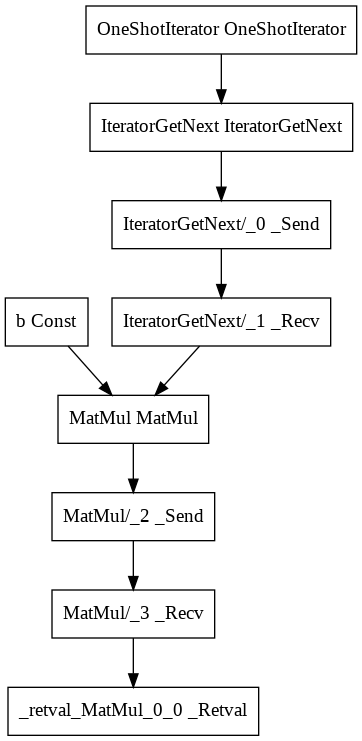

In [29]:
import pydot
from itertools import chain


def tf_graphs_to_dot(graph_defs):
    dot = pydot.Dot()
    dot.set('rankdir', 'TD')
    dot.set('concentrate', True)
    dot.set_node_defaults(shape='record')
    
    # dot.set('labelloc','t')
    # dot.set('label', graph_def.node[0].device)

    for g in graph_defs:
      
      for c_node in g.node:
          node = pydot.Node(c_node.name, label=(c_node.name+' '+c_node.op))#c_node.device)
          dot.add_node(node)   
          for c_input in c_node.input:
              dot.add_edge(pydot.Edge(c_input, c_node.name))

      #all_ops = in_graph.get_operations()

      #all_tens_dict = {k: i for i,k in enumerate(set(chain(*[c_op.outputs for c_op in all_ops])))}
      #for c_node in all_tens_dict.keys():
      #    node = pydot.Node(c_node.name)#, label=label)
      #    dot.add_node(node)
      #for c_op in all_ops:
      #    for c_output in c_op.outputs:
      #        for c_input in c_op.inputs:
      #            dot.add_edge(pydot.Edge(c_input.name, c_output.name))
    return dot
  
  
  
  
  
from IPython.display import Image, display

def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)
  
  
from IPython.display import SVG

def show_dot_graph(g=None):
    if g is None:
        g = [tf.get_default_graph().as_graph_def()]
    pdot = tf_graphs_to_dot(g)
    viewPydot(pdot)
  
  
  
#show_dot_graph(metadata.partition_graphs)





from google.protobuf import text_format
graph_def = tf.GraphDef()
for g in metadata.partition_graphs:
  s = text_format.MessageToString(g)
  text_format.Merge(s, graph_def)
  

s = {}
r = []
for n in graph_def.node:
  if n.op == '_Send':
    s[n.experimental_debug_info.original_node_names[0]] = n
  elif n.op == '_Recv':
    r.append(n)
    
for n_r in r:
  n_s = s.get(n_r.experimental_debug_info.original_node_names[0])
  if not n_s == None:
     n_r.input.append(n_s.name) 

#print(graph_def)  

show_dot_graph([graph_def])
  
show_graph(graph_def)

In [30]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime!')
  use_tpu = False
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)  
  use_tpu = True

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint(devices)
  

  
#  tf.logging.set_verbosity(tf.logging.INFO)
#generator = tf.contrib.tpu.keras_to_tpu_model(generator_,
#    strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)))



ERROR: Not connected to a TPU runtime!


In [0]:
import functools
def eager(func):
    @functools.wraps(func)
    def eager_func(*args, **kwargs):
      with tf.Session() as sess:
         sess.run(tf.contrib.eager.py_func(func, inp=list(kwargs.values()), Tout=[]))
    return eager_func

## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.
* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [32]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL, 
                                      extract=True,
                                      cache_dir="/content")

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

print(PATH)

30171136/30168306 [==============================] - 1s 0us/step
/content/datasets/facades/


In [0]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



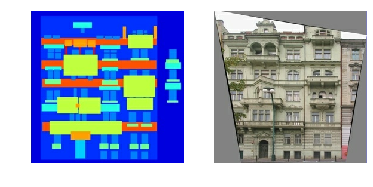

In [35]:
@eager
def test_load():
  global inp, re
  inp, re = load(PATH+'train/100.jpg')
  plt.figure(figsize=(6, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(inp/255.0)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(re/255.0)
  plt.axis('off')

test_load()

In [0]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize_images(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize_images(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  return input_image, real_image

In [0]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  
  return cropped_image[0], cropped_image[1]

In [0]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  
  return input_image, real_image

In [0]:
#@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  # random mirroring
  condition = tf.random.uniform(()) > 0.5
  # if (condition):
  #  input_image = tf.image.flip_left_right(input_image)
  #  real_image = tf.image.flip_left_right(real_image)
  input_image = tf.cond(condition, lambda: input_image, lambda: tf.image.flip_left_right(input_image)) 
  real_image = tf.cond(condition, lambda: real_image, lambda: tf.image.flip_left_right(real_image))   
    
  return input_image, real_image

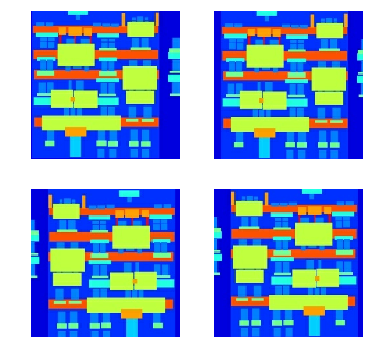

In [40]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally 


@eager
def test_jitter():
  plt.figure(figsize=(6, 6))
  for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)  
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
  plt.show()
  
test_jitter()

In [0]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return (input_image), (real_image, tf.constant(1.0))

In [0]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH) 
  input_image, real_image = normalize(input_image, real_image)
  
  return input_image, real_image

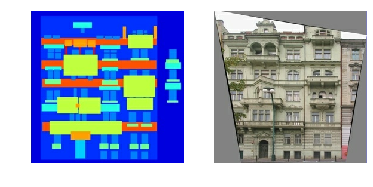

In [43]:


@eager
def test_load_image_train():
  inp, re = load(PATH+'train/100.jpg')
  plt.figure(figsize=(6, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(inp/255.0)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(re/255.0)
  plt.axis('off')
  
test_load_image_train()

## Input Pipeline

In [0]:
def create_train_dataset():
  train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
  train_dataset = train_dataset.shuffle(BUFFER_SIZE)
  train_dataset = train_dataset.map(load_image_train) #,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_dataset = train_dataset.batch(BATCH_SIZE)
  train_dataset = train_dataset.repeat().prefetch(1)
  return train_dataset;

In [0]:
def create_test_dataset():
  test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
  # shuffling so that for every epoch a different image is generated 
  # to predict and display the progress of our model.
  test_dataset = test_dataset.shuffle(BUFFER_SIZE)
  test_dataset = test_dataset.map(load_image_test)
  test_dataset = test_dataset.batch(BATCH_SIZE)
  test_dataset = test_dataset.repeat()
  return test_dataset;

In [46]:
   
train_dataset=create_train_dataset()    
test_dataset=create_test_dataset()

Instructions for updating:
Colocations handled automatically by placer.


## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).
 
    

In [0]:
OUTPUT_CHANNELS = 3

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
    
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [49]:
@eager
def test_down():
  global down_result
  down_model = downsample(3, 4)
  down_result = down_model(tf.expand_dims(inp, 0))
  print (down_result.shape)
  
test_down()

(1, 128, 128, 3)


In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same', 
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())
  
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [51]:
@eager
def test_up():
  global down_result
  up_model = upsample(3, 4)
  up_result = up_model(down_result)
  print (up_result.shape)
  
test_up()

(1, 256, 256, 3)


In [0]:
def Generator(name="Generator"):
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, 
                                         strides=2, 
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate() 

  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE, name="generator_condition_input")
  x = inputs
  
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    #x = concat([x, skip])
    x = tf.keras.layers.concatenate([x, skip]) 

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x , name=name )

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_condition_input (Inpu (1, 256, 256, 3)     0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (1, 128, 128, 64)    3072        generator_condition_input[0][0]  
__________________________________________________________________________________________________
sequential_1 (Sequential)       (1, 64, 64, 128)     131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (1, 32, 32, 256)     525312      sequential_1[0][0]          

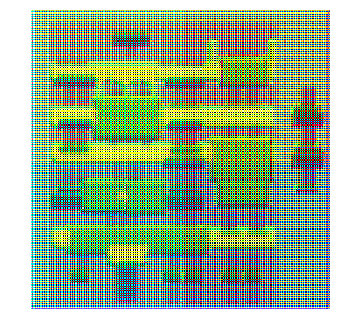

In [53]:
@eager
def test_generator():
  global gen_output
  generator = Generator(name="G")
  generator.summary()
  gen_output = generator(inp[tf.newaxis,...], training=False)
  plt.imshow(gen_output[0,...]*0.5+0.5)
  plt.axis('off')
  
test_generator()  

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake. 
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [0]:
def Discriminator( name="Discriminator"):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], batch_size=BATCH_SIZE, name="discriminator_condition_input")
  tar = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], batch_size=BATCH_SIZE, name="discriminator_target_input")
  
  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
  
  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, 
                                kernel_initializer=initializer, 
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
  
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv) 

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
  
  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
  return tf.keras.Model(inputs=[inp, tar], outputs=last, name=name )


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_condition_input ( (1, 256, 256, 3)     0                                            
__________________________________________________________________________________________________
discriminator_target_input (Inp (1, 256, 256, 3)     0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (1, 256, 256, 6)     0           discriminator_condition_input[0][
                                                                 discriminator_target_input[0][0] 
__________________________________________________________________________________________________
sequential (Sequential)         (1, 128, 128, 64)    6144        concatenate[0][0]                
__________

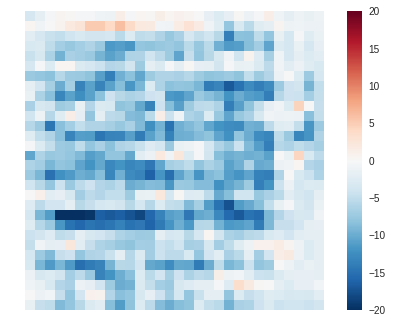

In [55]:
@eager
def test_discriminator():
  global gen_output
  discriminator = Discriminator(name="D")
  discriminator.summary()
  disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
  plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
  plt.colorbar()
  plt.axis('off')
  
test_discriminator()

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss
  
* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

In [0]:
LAMBDA = 100

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

## Checkpoints (Object-based saving)

## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* This entire procedure is shown in the images below.

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/images/dis.png?raw=1)


---


![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/generative/images/gen.png?raw=1)

## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and **voila!**

In [0]:
EPOCHS = 2
steps_per_epoch = 40//BATCH_SIZE

In [0]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get 
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [62]:
if tf.executing_eagerly():
  print("eager")
else:
  print("static")
  



generator = Generator()
discriminator = Discriminator()


#if use_tpu:
#  generator = tf.contrib.tpu.keras_to_tpu_model(generator,
#    strategy=tf.contrib.tpu.TPUDistributionStrategy(
#        tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)))
#  discriminator = tf.contrib.tpu.keras_to_tpu_model(discriminator,
#    strategy=tf.contrib.tpu.TPUDistributionStrategy(
#        tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)))




print("generator: ",generator)
print("discriminator: ",discriminator)

#generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5, beta2=0.999, epsilon=1e-08, name="generator_optimizer")
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.999, epsilon=1e-08, name="discriminator_optimizer")


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


def train_op(iterator):
    
    with tf.name_scope("train_op"):

      (input_image), (target, label) = iterator.get_next()

      #inp = input_image
      #tar = target

      #gen_output = generator(inp)
      #disc_gen_output = discriminator([inp, gen_output])
      #disc_real_output = discriminator([inp, tar])

      
      inp = tf.keras.layers.InputLayer(name='train_input_image', input_tensor=input_image)
      tar = tf.keras.layers.InputLayer(name='train_target_image', input_tensor=target)
      #tar = tf.keras.layers.InputLayer(input_shape=[IMG_WIDTH, IMG_HEIGHT, 3], name='train_target_image', batch_size=BATCH_SIZE, input_tensor=target)
    
      gen_output = generator(inp.output)
      disc_gen_output = discriminator([inp.output,gen_output])
      disc_real_output = discriminator([inp.output,tar.output])
    
    #  train_model = tf.keras.Model(inputs=[inp, tar], outputs=[gen_output,disc_gen_output,disc_real_output], name="train_model" )
      
      
      
      def log_eps(i):
          return tf.log(i+1e-11)

      dloss = - tf.reduce_mean(log_eps(1-disc_gen_output) + .1 * log_eps(1-disc_real_output) + .9 * log_eps(disc_real_output))
      gloss = - tf.reduce_mean(log_eps(disc_gen_output))

      #lr,b1 = 1e-4,.2 # otherwise won't converge.
      #optimizer = Adam(lr,beta1=b1)


      grad_loss_wd = discriminator_optimizer.compute_gradients(dloss, discriminator.trainable_weights)
      update_wd = discriminator_optimizer.apply_gradients(grad_loss_wd)

      #generator_optimizer
      grad_loss_wg = generator_optimizer.compute_gradients(gloss, generator.trainable_weights)
      update_wg = generator_optimizer.apply_gradients(grad_loss_wg)

      def get_internal_updates(model):
          # get all internal update ops (like moving averages) of a model
          inbound_nodes = model.inbound_nodes
          input_tensors = []
          for ibn in inbound_nodes:
              input_tensors += ibn.input_tensors
          updates = [model.get_updates_for(i) for i in input_tensors]
          return updates

      #other_parameter_updates = [get_internal_updates(m) for m in [discriminator, generator]]
      #other_parameter_updates = get_internal_updates(train_model)

      #print('other_parameter_updates for the models:')
      #pprint(other_parameter_updates)

      train_step = [update_wd, update_wg]#, other_parameter_updates]
      losses = [dloss, gloss]
      data = [input_image, target, gen_output]

      #from tf.keras import backend as K
      #print K.learning_phase()
      #learning_phase = K.learning_phase()

    return train_step, losses, data


def trainX(dataset, epochs):  

  
  iterator = dataset.make_initializable_iterator()
  
  train_step, losses, data = train_op(iterator)

  
  sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
  #sess = tf.Session()
  with sess.as_default():
  
    sess.run([iterator.initializer, tf.global_variables_initializer()])


    for epoch in range(epochs):

      start = time.time()
      print('Epoch', epoch)
      #progbar = tf.keras.utils.Progbar(target=steps_per_epoch, stateful_metrics='loss')

      for step in range(steps_per_epoch):  
        #train_result, loss_values, images = 
        sess.run([train_step, losses, data])

      #clear_output(wait=True)
      #for inp, tar in test_dataset.take(1):
      #  generate_images(generator, inp, tar)

      # saving (checkpoint) the model every 20 epochs
      if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix, session=sess)

      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                          time.time()-start))
  sess.close()


  
  
  
trainX(train_dataset, EPOCHS)

#show_graph()

#input("Press Enter to continue...")

static
generator:  <tensorflow.python.keras.engine.training.Model object at 0x7f3cf75fc7f0>
discriminator:  <tensorflow.python.keras.engine.training.Model object at 0x7f3cf57c53c8>
Epoch 0
Time taken for epoch 1 is 9.090392827987671 sec

Epoch 1
Time taken for epoch 2 is 6.645678520202637 sec



In [0]:
POOL_SIZE=16


def save_jpg(image, filepath):
  image = tf.cast((image*0.5+0.5)*255, dtype=np.uint8)
  image_data = tf.image.encode_jpeg(image, format='rgb', quality=100)
  tf.io.write_file(filepath,image_data)


def save_to_pool(inp, outp, label, n):
  sidebyside = tf.concat([outp,inp],1)
  filepath = PATH+'pool/'+str(label)+'/'+str(n)+'.jpg'
  #print(filepath)
  save_jpg(sidebyside,filepath)
    
    

        
@eager
def prepare_pool():
  
  #import os
  #import shutil
  #shutil.rmtree(PATH+'pool', ignore_errors=True)
  #os.makedirs(PATH+'pool/0/')
  #os.makedirs(PATH+'pool/1/')
  
  train_dataset = create_train_dataset() 
  iterator = train_dataset.make_one_shot_iterator()
  
  for i in range(POOL_SIZE//BATCH_SIZE):
    #input_image, target = train_dataset.take(1)
    (inp), (tar, _) = iterator.get_next()
    
    for j in range(BATCH_SIZE):
      input_image = inp[j, :, : ,:]
      target = tar[j, :, : ,:]
      
      n = i*BATCH_SIZE+j
      
      save_to_pool(input_image, target, 1, n)

      fake = tf.random.uniform(target.get_shape().as_list())*2-0.5
      fake = (fake+input_image)*0.5
      
      save_to_pool(input_image, fake, 0, n)

prepare_pool()

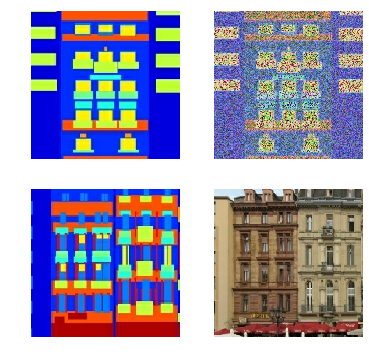

In [64]:


def get_pool_image(label):
  s_label = tf.as_string(tf.cast(label, dtype=tf.dtypes.int32))
  r = tf.as_string(tf.random.uniform([], minval=0, maxval=POOL_SIZE, dtype=tf.dtypes.int32))
  path = PATH+'pool/'+tf.as_string(label)+'/'+r+'.jpg'
  (inp), (re, _) = load_image_train(path)
  label = tf.cast(label, dtype=tf.dtypes.float32)
  return (inp, re), (label)

def get_pool_image_1(n):
  return get_pool_image(tf.constant(1))

def get_pool_image_0(n):
  return get_pool_image(tf.constant(0))

def get_pool_image_alternating(n):
  label = tf.mod(n,2)
  return get_pool_image(label)
  
                           
@eager
def test_pool():
  (inp0, re0), (label0) = get_pool_image_0(0)
  (inp1, re1), (label1) = get_pool_image_1(1)
  
  plt.figure(figsize=(6, 6))
  plt.subplot(2, 2, 1)
  plt.imshow(inp0*0.5+0.5)
  plt.axis('off')
  plt.subplot(2, 2, 2)
  plt.imshow(re0*0.5+0.5)
  plt.axis('off')
  plt.subplot(2, 2, 3)
  plt.imshow(inp1*0.5+0.5)
  plt.axis('off')
  plt.subplot(2, 2, 4)
  plt.imshow(re1*0.5+0.5)
  plt.axis('off')

test_pool()                           


In [0]:

pool_dataset_1 = tf.data.Dataset.range(POOL_SIZE).map(get_pool_image_1).batch(BATCH_SIZE).repeat().prefetch(1)
pool_dataset_0 = tf.data.Dataset.range(POOL_SIZE).map(get_pool_image_0).batch(BATCH_SIZE).repeat().prefetch(1)

pool_dataset = tf.data.Dataset.range(POOL_SIZE).map(get_pool_image_alternating).batch(BATCH_SIZE).repeat().prefetch(1)

In [0]:
def into_pool(inp, outp, label):
  for j in range(BATCH_SIZE):
    input_image = inp[j, :, : ,:]
    target = outp[j, :, : ,:]
    r = tf.random.uniform([], minval=0, maxval=POOL_SIZE, dtype=tf.dtypes.int32).eval()
    #label = label.eval()
    save_to_pool(input_image, target, label, r)

    

def trainB(dataset, epochs):                   
                           
  steps_per_epoch = 10
  sess = None

  trainset_iterator = dataset.make_initializable_iterator()
  
  sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
  #sess = tf.Session()
  with sess.as_default():

    sess.run(trainset_iterator.initializer)
    sess.run(tf.global_variables_initializer())

    discriminator.trainable = True
    #discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
    generator.trainable = True
    #generator.compile(optimizer=generator_optimizer, loss='binary_crossentropy')

    input_image = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
    sample = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
    disc_output_30x30 = discriminator([input_image,sample])
    disc_output = tf.keras.layers.AveragePooling2D(pool_size=30)(disc_output_30x30)
    discriminator1x1 =  tf.keras.Model(inputs=[input_image, sample], outputs=[disc_output], name="D_1x1")
    discriminator1x1.trainable = True
    discriminator1x1.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
    discriminator1x1.summary()

    #shape = discriminator.get_input_shape_at(0)[1:]
    #fake_input, real_input = tf.keras.layers.Input(shape), tf.keras.layers.Input(shape)
    #discriminator2batch = tf.keras.Model([fake_input, real_input], [discriminator(fake_input), discriminator(real_input)])
    #discriminator.trainable = True
    #discriminator2batch.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
    #discriminator2batch.summary()

    input_image = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3], batch_size=BATCH_SIZE)
    gen_output = generator(input_image)
    disc_gen_output = discriminator1x1([input_image, gen_output])
    generator_discriminator =  tf.keras.Model(inputs=input_image, outputs=[gen_output, disc_gen_output])
    generator_discriminator.trainable = True
    discriminator1x1.trainable=False
    generator_discriminator.compile(optimizer=generator_optimizer,
                                    loss=['mae', 'binary_crossentropy'],
                                    loss_weights=[10, 1],
                                    metrics=['mae', 'binary_crossentropy'])
   # generator_discriminator.train_function = None
   # generator_discriminator.test_function = None
   # generator_discriminator._compile_metrics_tensors['predictions'] = generator_discriminator.outputs
   # generator_discriminator.metrics_names += ['predictions']
    generator_discriminator.summary()


    for epoch in range(epochs):

      start = time.time()
      print('Epoch', epoch)

      for step in range(steps_per_epoch):  
        print('Step', step)

        start_s = time.time()

        #todo no pooling of reals
        (input_image), (target, label) = sess.run(trainset_iterator.get_next())  
        into_pool(input_image,target,1)
        gen_img = generator.predict(input_image)
        into_pool(input_image,gen_img,0)
        print ('Time taken for pool step {} is {} sec'.format(step + 1,time.time()-start_s))

        start_s = time.time()

        discriminator1x1.trainable=False
        g_loss, predictions = generator_discriminator.train_on_batch(dataset)

        print ('Time taken for gen step {} is {} sec'.format(step + 1,time.time()-start_s))

        start_s = time.time()

        discriminator1x1.trainable=True
        d_loss_1 = discriminator1x1.train_on_batch(pool_dataset_1) 
        d_loss_0 = discriminator1x1.train_on_batch(pool_dataset_0) 
        dloss = d_loss_1+d_loss_0

        print ('Time taken for disc step {} is {} sec'.format(step + 1,time.time()-start_s))

      # saving (checkpoint) the model every 20 epochs
      if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

  
  sess.close()
    



trainB(train_dataset, EPOCHS)

#show_graph()

#input("Press Enter to continue...")
  

Time taken for epoch 2 is 7.9697654247283936 sec

static


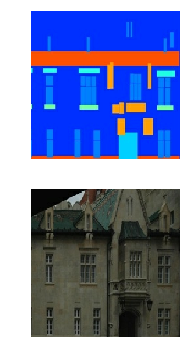

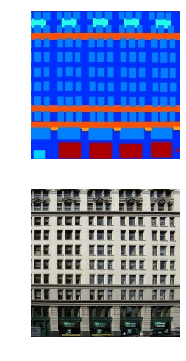

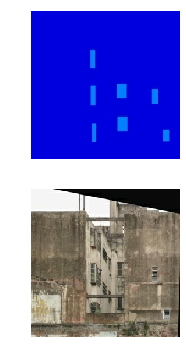

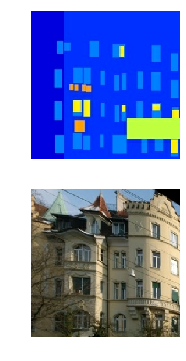

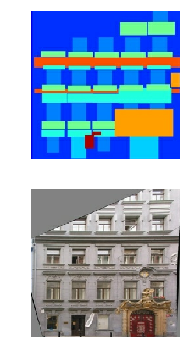

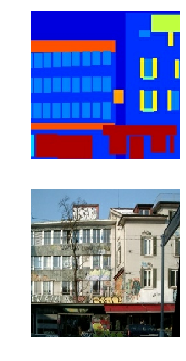

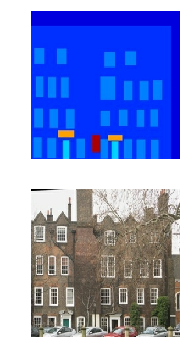

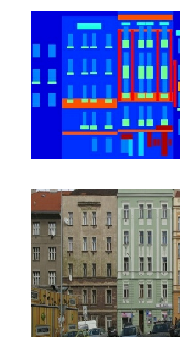

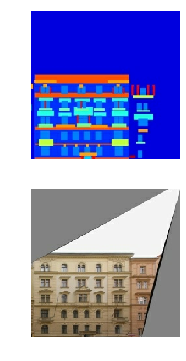

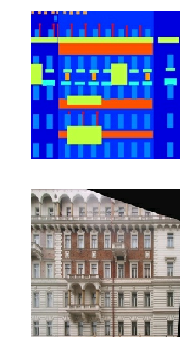

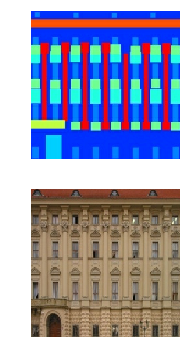

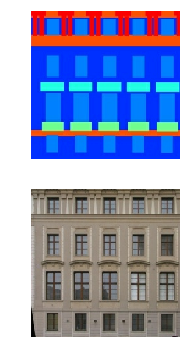

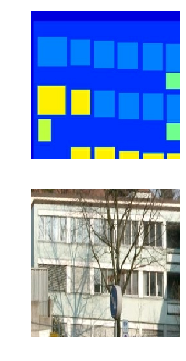

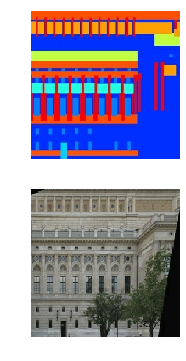

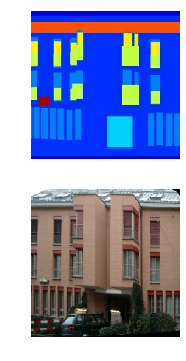

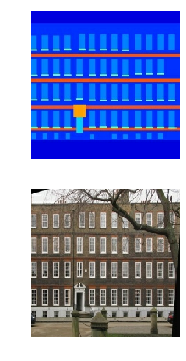

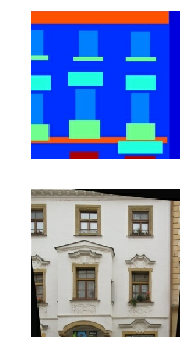

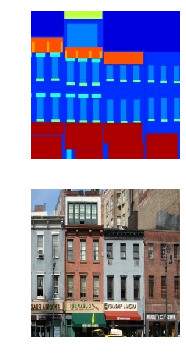

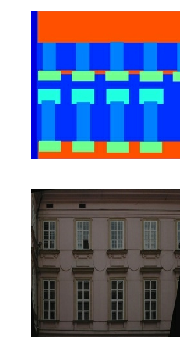

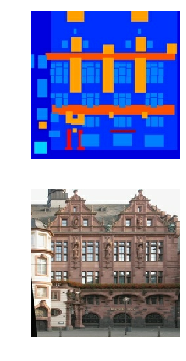

In [104]:
#@tf.function
@eager
def train_step(input_image, target):
  
  
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

def train(dataset, epochs):  
  
  steps_per_epoch = 10
  sess = None
  
  if tf.executing_eagerly():
    print("eager")
    iterator = dataset.make_one_shot_iterator()    
  else:
    print("static")
    iterator = dataset.make_initializable_iterator()
    sess = tf.Session()
    sess.run(iterator.initializer)
    sess.run(tf.global_variables_initializer())
    a, b = sess.run(iterator.get_next())
  
   
    
  for epoch in range(epochs):
    
    start = time.time()
    print('Epoch', epoch)
    progbar = tf.keras.utils.Progbar(target=steps_per_epoch, stateful_metrics='loss')
    
    for step in range(steps_per_epoch):  
    #for input_image, target in dataset:
    
        if tf.executing_eagerly():
          input_image, target = iterator.get_next()
          train_step(input_image, target)
        else:
            with sess.as_default():
              (input_image), (target, _) = sess.run(iterator.get_next())

              inp = input_image[0,:,:,:]
              tgt = target[0,:,:,:]

              #print(inp.dtype)  
              #print(inp)

              plt.figure(figsize=(6, 6))
              plt.subplot(2, 1, 1)
              plt.imshow(inp*0.5+0.5)
              plt.axis('off')
              plt.subplot(2, 1, 2)
              plt.imshow(tgt*0.5+0.5)
              plt.axis('off')

              #train_step(input_image=input_image, target=target)
              

    clear_output(wait=True)
    #for inp, tar in test_dataset.take(1):
    #  generate_images(generator, inp, tar)
          
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    
     
  if tf.executing_eagerly():
    print("eager")
  else:
    sess.close()
    print("static")
  

  
train(train_dataset, EPOCHS)

## Restore the latest checkpoint and test

In [0]:
!ls {checkpoint_dir}

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Testing on the entire test dataset

In [0]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset:
  generate_images(generator, inp, tar)